## Assessment 1: Deep Learning

1) Answer all questions.
2) This assessment is open-book. You are allowed to refer to any references including online materials, books, notes, codes, github links, etc.
3) Copy this notebook to your google drive (click **FILE** > **save a copy in Drive**)
4) Upload the answer notebook to your github. 
5) Submit the assessment by sharing the link to your answer notebook. 





**QUESTION 1** 

One day while wandering around a clothing store at KL East Mall, you stumbled upon a person who is choosing a dress for Hari Raya. It turns out that the person is visually impaired and had a hard time distinguishing between an abaya and a kebaya. To help people with the similar situation, you then decided to develop an AI system to identify the type of clothes using a Convolutional Neural Networks (ConvNet). In order to train the network, you decide to use the Fashion MNIST dataset which is freely available on Pytorch.


a) Given the problem, what is the most appropriate loss function to use? Justify your answer. **[5 marks]**


<span style="color:blue">
    ANSWER:  The most appropriate loss function to use is the cross entropy loss. It computes the loss between input and target. It is useful when training a classification problem with classes.
</span>

b) Create and train a ConvNet corresponding to the following CNN architecture (with a modification of the final layer to address the number of classes). Please include **[10 marks]**:

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) Define your training loop.

    4) Output the mean accuracy for the whole testing dataset.

    



![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/LeNet.png)

In [16]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary


###############################################
######## THE REST OF YOUR CODES HERE ##########
###############################################


In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [18]:
# 1) Dataloader
batch_size = 4


trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

60000
10000


In [19]:
# 2) Model definition
#CNN 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
# 3) Training loop
model = CNN() # need to instantiate the network to be used in instance method

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
)

In [21]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [22]:
# Train
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.5263, Accuracy: 80.4950%, 
		Validation : Loss : 0.3979, Accuracy: 85.6500%, Time: 73.3406s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.3520, Accuracy: 87.0967%, 
		Validation : Loss : 0.3372, Accuracy: 87.6800%, Time: 73.4143s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.3127, Accuracy: 88.4867%, 
		Validation : Loss : 0.3387, Accuracy: 87.5600%, Time: 72.9992s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.2898, Accuracy: 89.3417%, 
		Validation : Loss : 0.3273, Accuracy: 88.1100%, Time: 72.8034s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2736, Accuracy: 89.8733%, 
		Validation : Loss : 0.3279, Accuracy: 87.9900%, Time: 73.6381s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2572, Accuracy: 90.3750%, 
		Validation : Loss : 0.2994, Accuracy: 89.0300%, Time: 73.2363s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.2456, Accuracy: 90.7733%, 
		Validation : Loss : 0.3271, Accuracy: 88.4100%, Time: 71.6891s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.2371, Accura

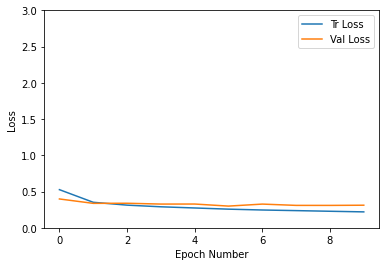

In [23]:
# 4) Output
# Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

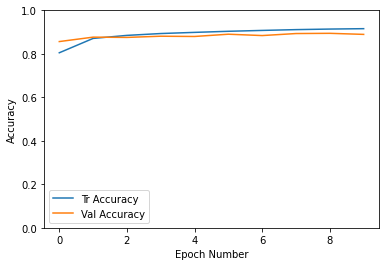

In [24]:
# Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

In [25]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 88 %


In [26]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: T-shirt/top is 76.5 %
Accuracy for class: Trouser is 98.0 %
Accuracy for class: Pullover is 78.5 %
Accuracy for class: Dress is 90.2 %
Accuracy for class: Coat  is 87.1 %
Accuracy for class: Sandal is 96.4 %
Accuracy for class: Shirt is 73.7 %
Accuracy for class: Sneaker is 94.0 %
Accuracy for class: Bag   is 97.3 %
Accuracy for class: Ankle boot is 97.8 %


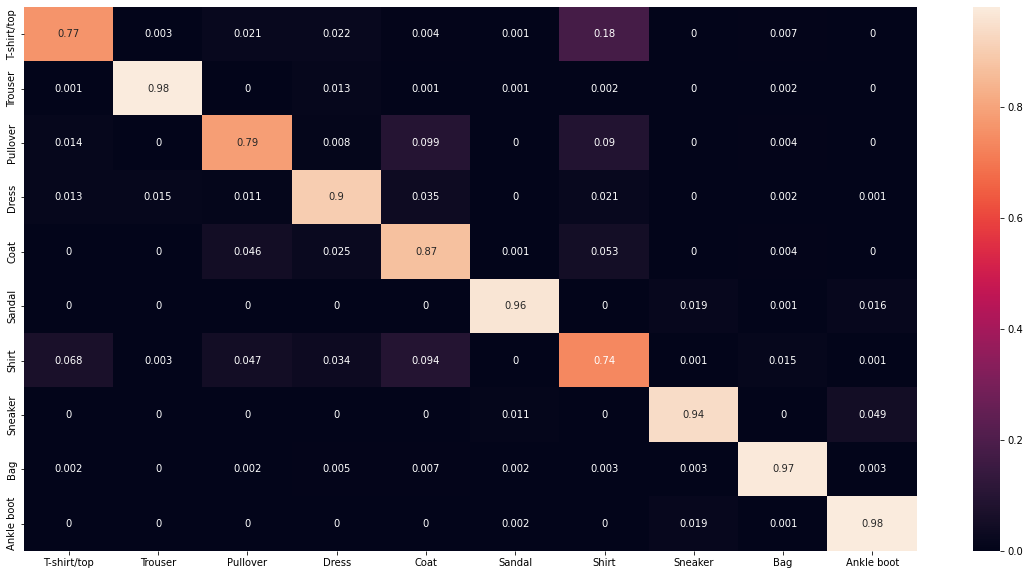

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.to('cpu')

# iterate over test data
for inputs, labels in testloader:
#         #reshape images so they can be fed to a nn.Linear()
#         inputs = inputs.view(inputs.size(0), -1)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')

c) Replace your defined CNN in b) with a pre-trained model. Then, proceed with a transfer learning and finetune the model for the Fashion MNIST dataset. **[10 marks]**

In [1]:
###############################################
###############YOUR CODES HERE ################
###############################################
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
batch_size = 4


trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(train_data_size)
print(test_data_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

60000
10000


In [4]:
my_resnet=models.resnet18(pretrained=True)
num_ftrs = my_resnet.fc.in_features

my_resnet.fc = nn.Linear(num_ftrs, 10)

my_resnet = my_resnet.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(my_resnet.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [28]:
my_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [6]:
num_epochs = 10
trained_model, history = train_and_validate(my_resnet, criterion, optimizer_ft, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.9587, Accuracy: 70.7700%, 
		Validation : Loss : 0.5549, Accuracy: 80.2700%, Time: 226.2364s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.5301, Accuracy: 83.1750%, 
		Validation : Loss : 0.5114, Accuracy: 83.9100%, Time: 215.7215s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.4288, Accuracy: 86.3567%, 
		Validation : Loss : 0.4670, Accuracy: 87.4400%, Time: 216.1997s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.4038, Accuracy: 87.3033%, 
		Validation : Loss : 0.4158, Accuracy: 87.4300%, Time: 214.5243s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.3500, Accuracy: 88.8833%, 
		Validation : Loss : 0.4478, Accuracy: 84.9000%, Time: 216.9555s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.3373, Accuracy: 89.1117%, 
		Validation : Loss : 0.3812, Accuracy: 89.8400%, Time: 213.5881s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.3137, Accuracy: 89.7317%, 
		Validation : Loss : 0.3485, Accuracy: 87.7400%, Time: 214.3396s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.3029,

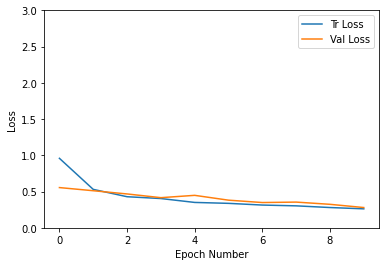

In [7]:
# Output
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

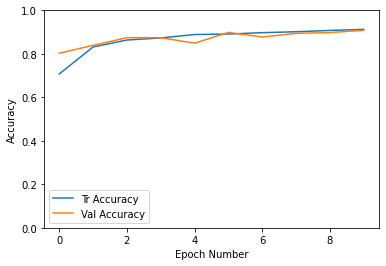

In [8]:
# Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = my_resnet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 90 %


In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
#         images = images.view(images.size(0), -1)
        outputs = my_resnet(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: T-shirt/top is 91.5 %
Accuracy for class: Trouser is 99.0 %
Accuracy for class: Pullover is 88.0 %
Accuracy for class: Dress is 92.7 %
Accuracy for class: Coat  is 86.7 %
Accuracy for class: Sandal is 97.8 %
Accuracy for class: Shirt is 60.4 %
Accuracy for class: Sneaker is 98.5 %
Accuracy for class: Bag   is 98.9 %
Accuracy for class: Ankle boot is 94.9 %


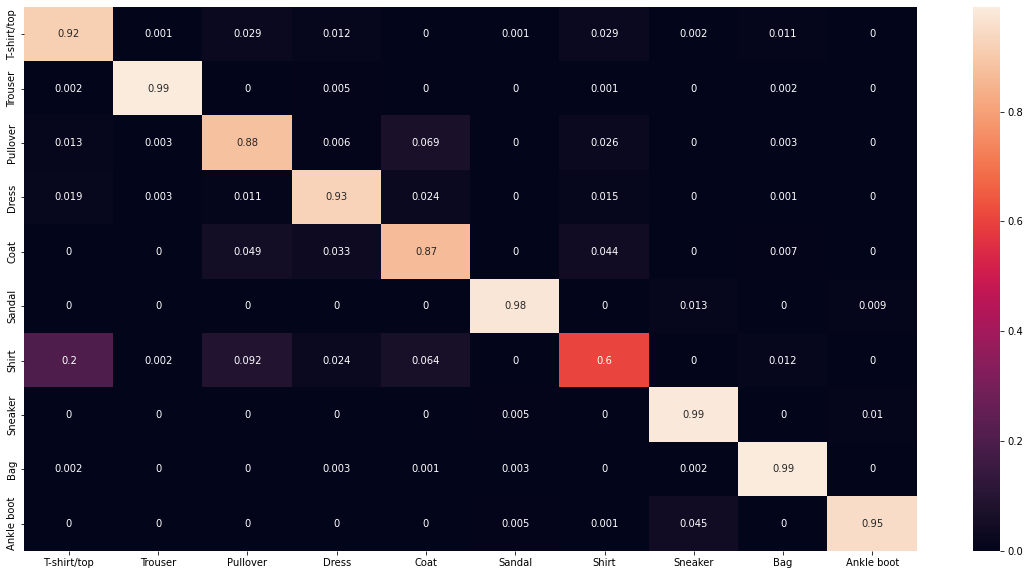

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

my_resnet.to('cpu')

# iterate over test data
for inputs, labels in testloader:
#         #reshape images so they can be fed to a nn.Linear()
#         inputs = inputs.view(inputs.size(0), -1)
        output = my_resnet(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')

d) Using model-centric methods, propose two (2) strategies that can be used to increase the accuracy of the model on the testing dataset. **[5 marks]**


<span style="color:blue">
    Two model-centric techniques that I propose are: 1) Increasing the batch size and use batch normalization.
    2) Using dropout.
 </span>

e) Next, implement the two proposed model-centric techniques for the same problem as in the previous question. **[15 marks]**

In [58]:
###############################################
###############YOUR CODES HERE ################
###############################################
my_resnet2=models.resnet18(pretrained=True)
num_ftrs = my_resnet2.fc.in_features #512

#fc layer represented by sequential of linear==>relu==>batch normalization==>dropout==>linear==>output(10 classes)
my_resnet2.fc = nn.Sequential(
                nn.Linear(num_ftrs, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(0.5),
                nn.Linear(256,10)
)

my_resnet2 = my_resnet2.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(my_resnet2.parameters(), lr=0.001, momentum=0.9)
my_resnet2

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [59]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [43]:
batch_size = 32 #new batch size


trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(train_data_size)
print(test_data_size)

60000
10000


In [46]:
num_epochs = 10
trained_model, history = train_and_validate(my_resnet2, criterion, optimizer_ft, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.4817, Accuracy: 83.2250%, 
		Validation : Loss : 0.3072, Accuracy: 88.8600%, Time: 44.0781s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.2982, Accuracy: 89.5067%, 
		Validation : Loss : 0.2698, Accuracy: 90.3000%, Time: 42.3106s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.2486, Accuracy: 91.1300%, 
		Validation : Loss : 0.2473, Accuracy: 90.8600%, Time: 42.3629s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.2209, Accuracy: 92.1633%, 
		Validation : Loss : 0.2347, Accuracy: 91.6500%, Time: 41.9213s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.1994, Accuracy: 92.7900%, 
		Validation : Loss : 0.2308, Accuracy: 91.6700%, Time: 42.3548s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.1842, Accuracy: 93.5150%, 
		Validation : Loss : 0.2332, Accuracy: 91.5600%, Time: 41.4449s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.1665, Accuracy: 94.0350%, 
		Validation : Loss : 0.2208, Accuracy: 92.0600%, Time: 41.3311s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.1510, Accura

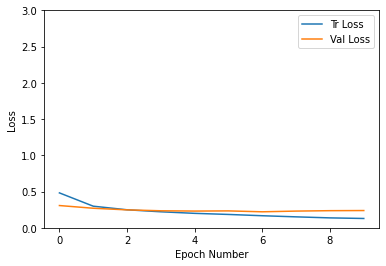

In [47]:
# Output
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

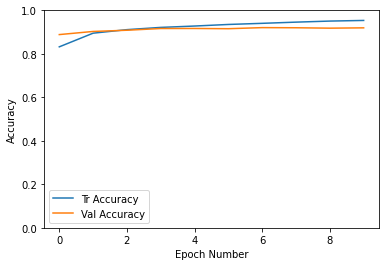

In [48]:
# Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

In [50]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = my_resnet2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 91 %


In [52]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
#         images = images.view(images.size(0), -1)
        outputs = my_resnet2(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: T-shirt/top is 86.3 %
Accuracy for class: Trouser is 98.1 %
Accuracy for class: Pullover is 84.4 %
Accuracy for class: Dress is 90.3 %
Accuracy for class: Coat  is 89.8 %
Accuracy for class: Sandal is 98.1 %
Accuracy for class: Shirt is 80.8 %
Accuracy for class: Sneaker is 96.7 %
Accuracy for class: Bag   is 98.3 %
Accuracy for class: Ankle boot is 96.8 %


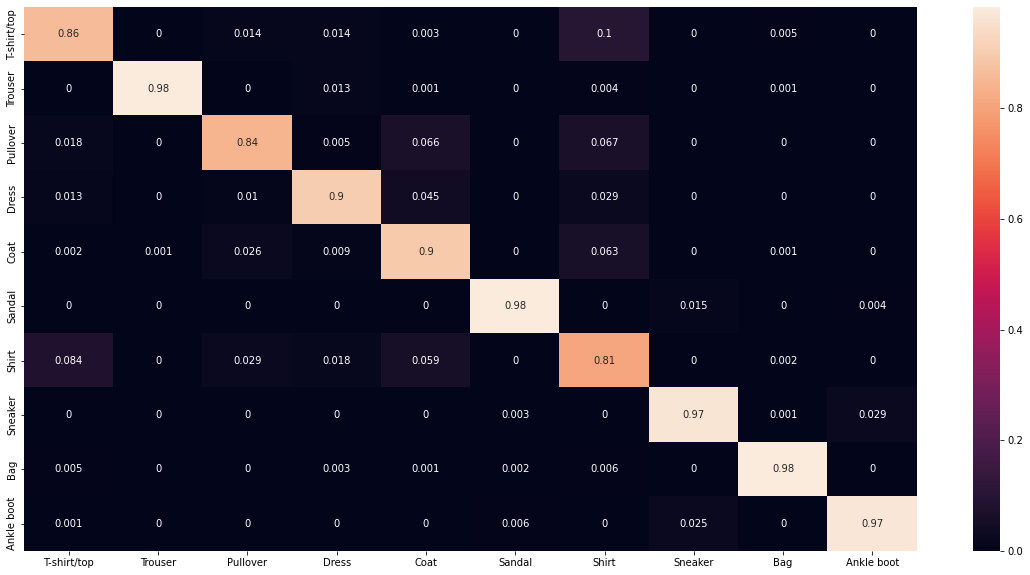

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

my_resnet2.to('cpu')

# iterate over test data
for inputs, labels in testloader:
#         #reshape images so they can be fed to a nn.Linear()
#         inputs = inputs.view(inputs.size(0), -1)
        output = my_resnet2(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')

f) Do you see any accuracy improvement? Whether it is a "yes" or "no", discuss the possible reasons contributing to the accuracy improvement/ unimprovement. **[5 marks]**

<span style="color:blue">
    Your answer here: Yes there is accuracy improvement. Batch normalization regularizes the model. Regularization reduces overfitting which leads to better test performance through better generalization. Dropout also helps improving performance of the model by making the network simpler. It makes the network simpler hence, prevents over fitting.  
</span>

g) In real applications, data-centric strategies are essential to train robust deep learning models. Give two (2) examples of such strategies and discuss how the strategies helps improving the model accuracy. **[5 marks]**

<span style="color:blue">
1) Performing data augmentation. It can be done by rotating, flipping or blurring the images.
2) Getting rid of the noise.
</span>

h) Next, implement the two proposed data-centric techniques for the same problem as in the previous question. **[10 marks]**

In [60]:
###############################################
##############YOUR CODES HERE #################
###############################################
transform2 = transforms.Compose(
    [torchvision.transforms.AutoAugment(), #using autoaugmentation for the images in dataset
     transforms.ToTensor(),
     transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [61]:
batch_size = 32 #new batch size


trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(train_data_size)
print(test_data_size)

60000
10000


In [62]:
num_epochs = 10
trained_model, history = train_and_validate(my_resnet2, criterion, optimizer_ft, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.6323, Accuracy: 77.5700%, 
		Validation : Loss : 0.3952, Accuracy: 85.7600%, Time: 55.9982s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.4263, Accuracy: 84.7800%, 
		Validation : Loss : 0.3489, Accuracy: 87.4400%, Time: 59.2636s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.3709, Accuracy: 86.4283%, 
		Validation : Loss : 0.3318, Accuracy: 87.9900%, Time: 59.5103s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.3422, Accuracy: 87.7550%, 
		Validation : Loss : 0.3021, Accuracy: 89.2000%, Time: 56.1908s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.3221, Accuracy: 88.2917%, 
		Validation : Loss : 0.2943, Accuracy: 89.2800%, Time: 55.1958s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.3041, Accuracy: 88.9750%, 
		Validation : Loss : 0.3010, Accuracy: 89.0800%, Time: 54.5414s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.2943, Accuracy: 89.4367%, 
		Validation : Loss : 0.2882, Accuracy: 89.5700%, Time: 55.1100s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.2804, Accura

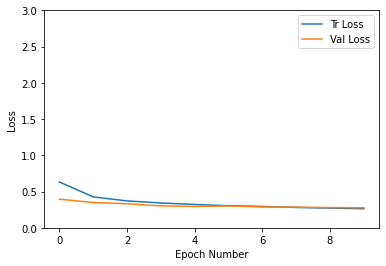

In [63]:
# Output
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

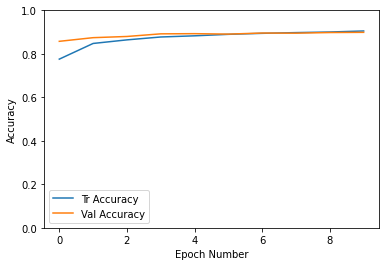

In [64]:
# Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

In [65]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = my_resnet2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 90 %


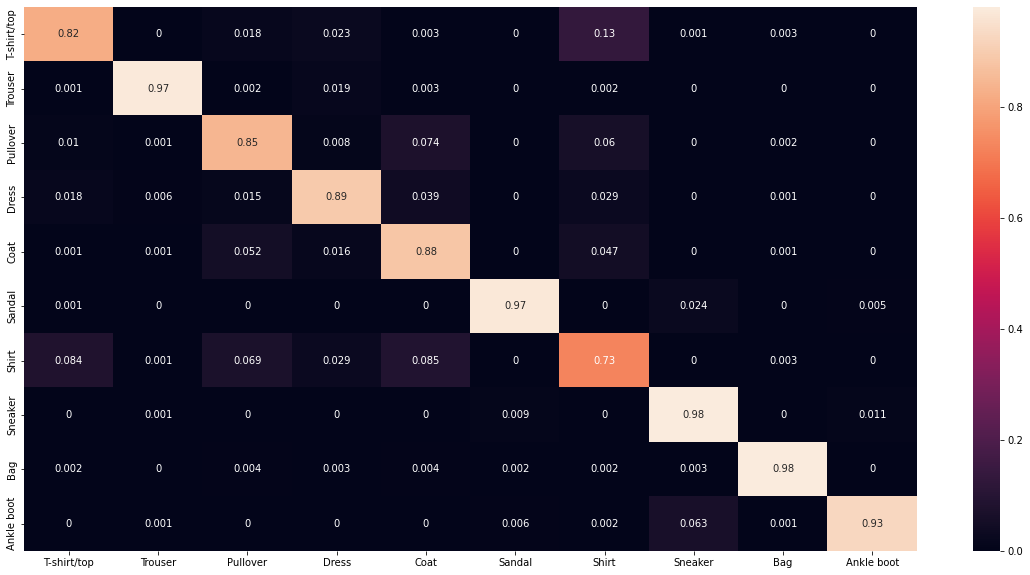

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

my_resnet2.to('cpu')

# iterate over test data
for inputs, labels in testloader:
#         #reshape images so they can be fed to a nn.Linear()
#         inputs = inputs.view(inputs.size(0), -1)
        output = my_resnet2(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')

**QUESTION 2** **[35 marks]**

Firstly, watch this video:

https://drive.google.com/file/d/1bsypahR7I3f_R3DXkfw_tf0BrbCHxE_O/view?usp=sharing

This video shows an example of masked face recognition where the deep learning model is able to detect and classify your face even when wearing a face mask. Using the end-to-end object detection pipeline that you have learned, develop your own masked face recognition such that the model should recognize your face even on face mask while recognize other persons as "others".

Deliverables for this question are:

- the model file. Change the name to <your_name>.pt file (e.g. hasan.pt).
- a short video (~10 secs) containing your face and your friends faces (for inference).

In [ ]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 13478, done.
remote: Counting objects: 100% (280/280), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 13478 (delta 201), reused 251 (delta 180), pack-reused 13198
Receiving objects: 100% (13478/13478), 13.25 MiB | 30.14 MiB/s, done.
Resolving deltas: 100% (9260/9260), done.
/content/yolov5
     |████████████████████████████████| 1.6 MB 4.7 MB/s 
     |████████████████████████████████| 145 kB 4.7 MB/s 
     |████████████████████████████████| 178 kB 44.0 MB/s 
     |████████████████████████████████| 1.1 MB 64.9 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 138 kB 72.9 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
Setup complete. Using torch 1.12.1+cu113 (Tesla T4)


In [ ]:
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="ultralytics")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=ultralytics


In [ ]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [ ]:
rf = Roboflow(api_key="BGFceF5wV8wDkahttddv")
project = rf.workspace("deep-learning-workshop-npfii").project("exam-ubfrg")
dataset = project.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/datasets/Exam-2 in yolov5pytorch:: 100%|██████████| 158/158 [00:00<00:00, 1826.22it/s]


In [ ]:
!python train.py --img 416 --batch 16 --epochs 150 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/datasets/Exam-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-187-g5ef69ef Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015,